In [2]:
import torch
from torch.optim import Adam

import pickle
import soundfile as sf
import IPython.display as ipd

from constants import *
from train import train_model
from early_stopper import EarlyStopper

from phase_loss import PhaseLoss
from magnitude_loss import MagnitudeLoss

from polar_dataset import build_data_loaders
from disk_utils import save_model, load_model
from plotter import plot_loss, plot_heatmaps, plot_waves
from predict import predict_polar, get_phases, make_wav

from models.model_18 import Model_18
from models.model_19 import Model_19

In [3]:
USE_GPU = True

num_epochs = 250
test_size = 0.2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not USE_GPU:
    device = torch.device("cpu")
    num_epochs = 1

In [4]:
with open("dataset/features/min_max.pkl", "rb") as handle:
    min_max = pickle.load(handle)

# model = Model_18()
model = Model_19(1, 1, 64)

part = "magnitude"
train_data_loader, test_data_loader = build_data_loaders(
    min_max, part=part, test_size=test_size)

criterion = MagnitudeLoss(
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part]
)
optimizer = Adam(model.parameters(), lr=3e-4)
es = EarlyStopper(7, 3e-6)

In [4]:
model, history = train_model(
    model,
    criterion,
    optimizer,
    device,
    train_data_loader, test_data_loader,
    es,
    num_epochs=num_epochs
)

Starting training...
E: 001/250	 T: 463.808119	 V: 64.342853
E: 002/250	 T: 41.396817	 V: 25.924826
E: 003/250	 T: 16.275863	 V: 13.411843
E: 004/250	 T: 9.093805	 V: 19.060122
E: 005/250	 T: 6.116309	 V: 10.207439
E: 006/250	 T: 4.702398	 V: 10.856667
E: 007/250	 T: 3.527439	 V: 9.323565
E: 008/250	 T: 2.884373	 V: 9.869829
E: 009/250	 T: 2.433206	 V: 9.189280
E: 010/250	 T: 2.084127	 V: 8.150126
E: 011/250	 T: 1.756901	 V: 9.912668
E: 012/250	 T: 1.533230	 V: 7.033118
E: 013/250	 T: 1.313082	 V: 7.522430
E: 014/250	 T: 1.106510	 V: 8.282516
E: 015/250	 T: 1.188545	 V: 6.927097
E: 016/250	 T: 0.786954	 V: 6.962852
E: 017/250	 T: 0.735869	 V: 7.110472
E: 018/250	 T: 0.601754	 V: 7.220292
E: 019/250	 T: 0.553821	 V: 7.027653
E: 020/250	 T: 0.509439	 V: 8.620694
E: 021/250	 T: 0.468713	 V: 7.451549
E: 022/250	 T: 0.430693	 V: 19.088509
Stopping early...


In [5]:
model.to(torch.device("cpu"))

Model_18(
  (enc1): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sig): Sigmoid()
  )
  (enc2): ConvBlock(
    (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sig): Sigmoid()
  )
  (enc3): ConvBlock(
    (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sig): Sigmoid()
  )
  (enc4): ConvBlock(
    (conv): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (sig): Sigmoid()
  )
  (bottleneck): ConvBlock(
    (conv): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm

In [ ]:
del model
torch.cuda.empty_cache()

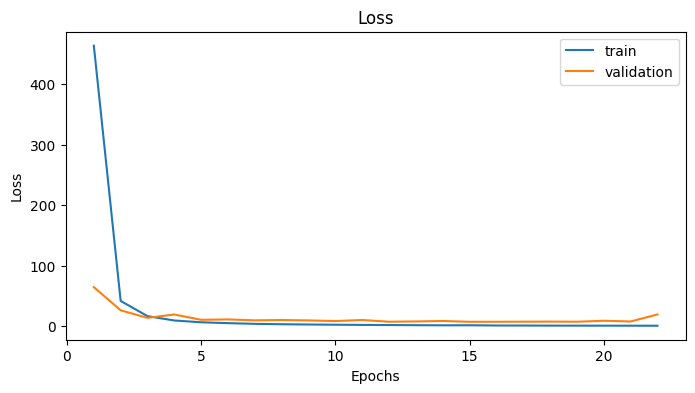

In [6]:
plot_loss(history, "Loss", start=0)

In [ ]:
predictions, targets = predict_polar(
    model,
    test_data_loader,
    min_max["ney"]["min"][part],
    min_max["ney"]["max"][part],
    limit=16)

08_Gtr_Gs_3/chunk_0, 08_Gtr_Gs_3/chunk_1, 08_Gtr_Gs_3/chunk_2, 08_Gtr_Gs_3/chunk_3
08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3
--------------------------------------------------
08_Gtr_Gs_3/chunk_4, 08_Gtr_Gs_3/chunk_5, 08_Gtr_Gs_3/chunk_6, 08_Gtr_Gs_3/chunk_7
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7
--------------------------------------------------
08_Gtr_Gs_3/chunk_8, 08_Gtr_Gs_3/chunk_9, 08_Gtr_Gs_3/chunk_10, 08_Gtr_Gs_3/chunk_11
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------


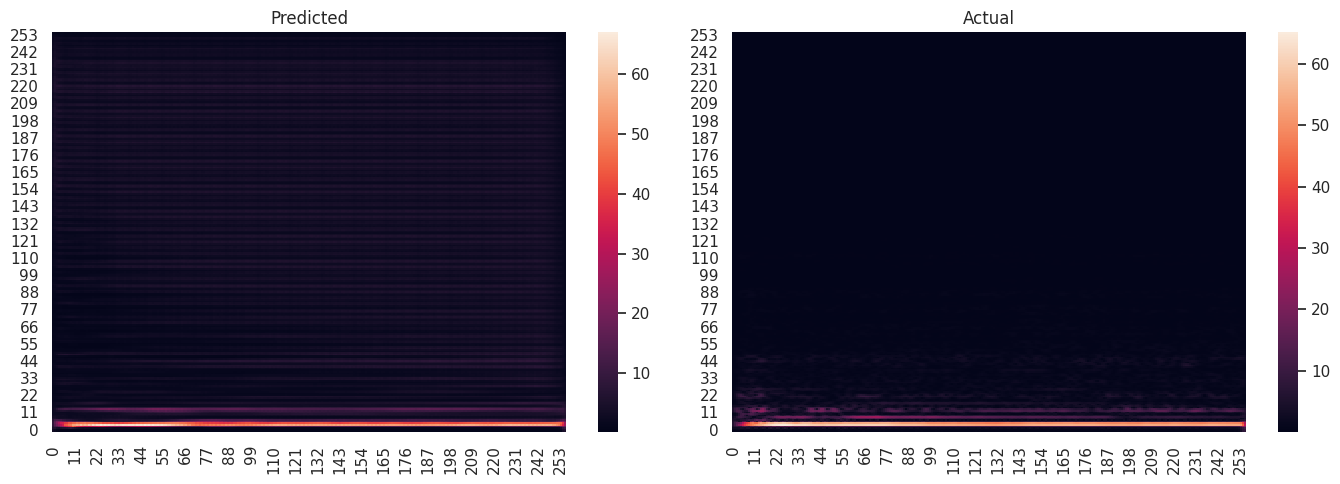

In [8]:
plot_heatmaps(predictions[0], targets[0])

In [ ]:
_, test_data_loader_phase = build_data_loaders(
    min_max, part="phase", test_size=test_size)
phases = get_phases(test_data_loader_phase, instrument="ney", limit=16)

08_Ney_Gs_3/chunk_0, 08_Ney_Gs_3/chunk_1, 08_Ney_Gs_3/chunk_2, 08_Ney_Gs_3/chunk_3
--------------------------------------------------
08_Ney_Gs_3/chunk_4, 08_Ney_Gs_3/chunk_5, 08_Ney_Gs_3/chunk_6, 08_Ney_Gs_3/chunk_7
--------------------------------------------------
08_Ney_Gs_3/chunk_8, 08_Ney_Gs_3/chunk_9, 08_Ney_Gs_3/chunk_10, 08_Ney_Gs_3/chunk_11
--------------------------------------------------


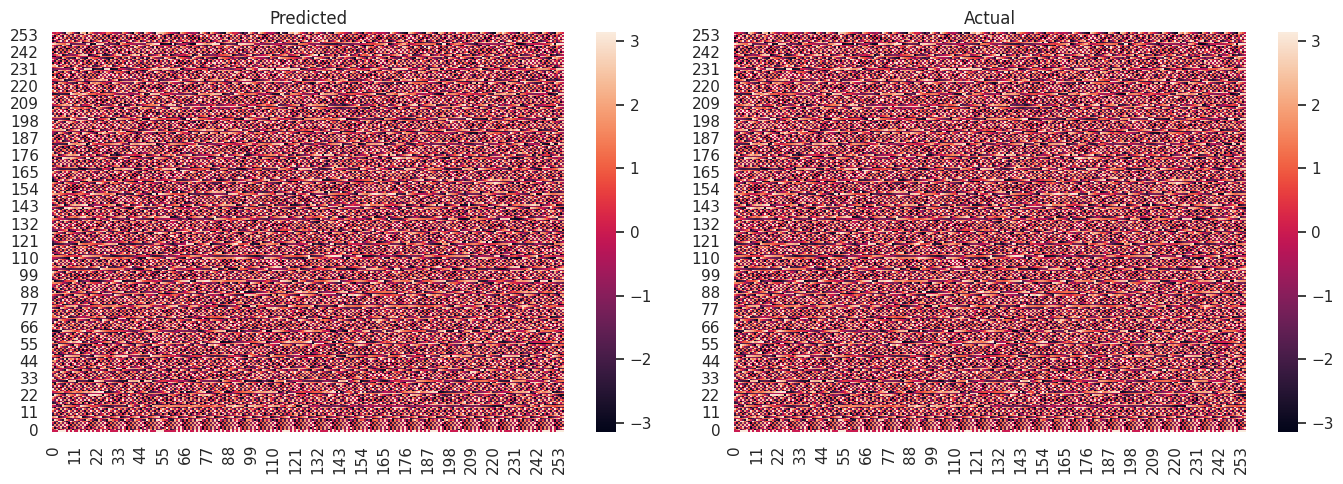

In [12]:
plot_heatmaps(phases[0], phases[0])

27584 27584


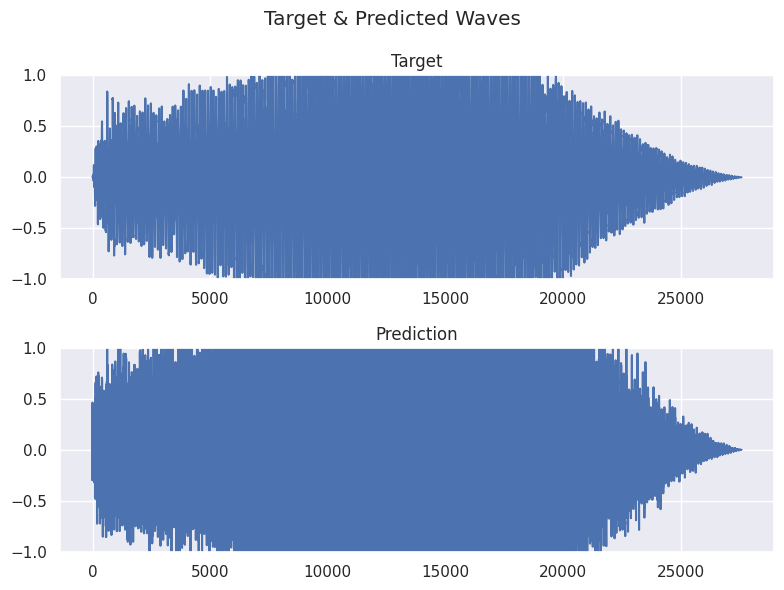

In [13]:
wave_prediction = make_wav(predictions, phases)
wave_target = make_wav(targets, phases)
print(len(wave_prediction), len(wave_target))
plot_waves(wave_target, wave_prediction)

In [ ]:
ipd.Audio(wave_target, rate=SR)

In [ ]:
ipd.Audio(wave_prediction, rate=SR)

In [14]:
sf.write("z_target.wav", wave_target, SR, format="wav")
sf.write("z_prediction.wav", wave_prediction, SR, format="wav")